In [1]:
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3 as sql

%matplotlib inline

# Reading data

#### 2013

In [2]:
# Reading the police call records of 2013 and keeping original data on police_2013or for further use
police_2013 = pd.read_csv('data/Metro_Nashville_Davidson_County_Calls_For_Police_Service__2013.csv')
police_2013or = police_2013.copy()

#### 2018

In [3]:
# Reading the police call records of 2018 and keeping original data on police_2018or for further use
police_2018 = pd.read_csv('data/Metro_Nashville_Davidson_County_Calls_For_Police_Service__2018.csv')
police_2018or = police_2018.copy()

## Cleaning columns and formating names
#### 2013

In [4]:
# Dropping some columns which we do not care
police_2013.drop(columns=['Tencode Suffix', 'Tencode Suffix Description', 'Block', 'Street Name', 'Reporting Area (RPA)', 'Mapped Location'], inplace = True)

# Changing column names by keeping the old names in a variable in case we need it in future
old_columns_2013 = police_2013.columns
new_columns_2013 = ['id', 'call_time', 'complaint_id', 'shift', 'tencode', 'tencode_desc', 'disposition', 'disposition_desc', 'unit', 'sector', 'zone', 'lat', 'lng']
police_2013.columns = new_columns_2013

#### 2018

In [5]:
# Dropping some columns which we do not care
police_2018.drop(columns=['Tencode Suffix', 'Tencode Suffix Description', 'Block', 'Street Name', 'Reporting Area (RPA)', 'Mapped Location'], inplace=True)

# Changing column names by keeping the old names in a variable in case we need it in future
old_columns_2018 = police_2018.columns
new_columns_2018 = new_columns_2013.copy()
police_2018.columns = new_columns_2018

## Removing time interval, which is not completed on 2018, from 2013 data 

#Finding the latest record on 2018

police_2018[police_2018.call_time.str.contains(police_2018['call_time'].max()[:5])]

#Oopss! It is from 2017 but not 2018. What is that?

print(police_2018['call_time'].max())

09/22/2017 09:44:50 AM

In [6]:
# Drop all the rows which are not from 2018, and reset index
police_2018.drop(police_2018[~police_2018.call_time.str.contains('2018')].index, inplace = True)
police_2018.reset_index(drop=True, inplace=True)

# Drop all the rows which are not from 2013, and reset index
police_2013.drop(police_2013[~police_2013.call_time.str.contains('2013')].index, inplace = True)
police_2013.reset_index(drop=True, inplace=True)

# Just keep the same call times for both 2013 and 2018, 
# since 2018 is incomplete take keep 2013 data if mo/dt is lower or equal to maximum mo/dt of 2018
police_2013 = police_2013[police_2013.call_time.str[:5]<=police_2018['call_time'].max()[:5]]

How could I be sure that the dataframe is sorted by call_time?

If it is not sorted by call_time, some index may be removed from not last lines but anywhere else. So I want to be sure the 
index number is not spoiled after removing.

# Investigating data

In [7]:
# Looking how many units got more than 1000 calls on 2013
count_calls_unit_2013 = np.array(police_2013['unit'].value_counts())
print('2013: '+str(sum(count_calls_unit_2013>=1000))+' units got more than 1000 calls')

# Looking how many units got more than 1000 calls on 2018
count_calls_unit_2018 = np.array(police_2018['unit'].value_counts())
print('2018: '+str(sum(count_calls_unit_2018>1000))+' units got more than 1000 calls')

2013: 317 units got more than 1000 calls
2018: 271 units got more than 1000 calls


That does not look so good I could put on a map somehow

### Cleaning location information to get rid of weird locations such as somewhere on Arkansas

In [8]:
# Looking the location information on original data
# Central Nashville location: lat 36.1612, lng -86.7775

print('\n',2013)
print('The min and max of latitudes: ',police_2013or['Latitude'].min(), police_2013or['Latitude'].max())
print('The min and max of longitudes: ',police_2013or['Longitude'].min(), police_2013or['Longitude'].max())

print('The number of all latitudes: ',sum(police_2013or['Latitude']>34))
print('The number of latitudes belong to Nashville: ',sum(abs(police_2013or['Latitude']-36.1612) <= 0.5))
print('The percentage of latitudes belong to Nashville: ',100*sum(abs(police_2013or['Latitude']-36.1612) <= 0.5)/sum(police_2013or['Latitude']>34))

print('The number of all longitudes: ',sum(police_2013or['Longitude']>-95))
print('The number of longitudes belong to Nashville: ',sum(abs(police_2013or['Longitude']+86.7775) <= 0.5))
print('The percentage of longitudes belong to Nashville: ',100*sum(abs(police_2013or['Longitude']+86.7775) <= 0.5)/sum(police_2013or['Latitude']>-95))

print('\n',2018)
print('The min and max of latitudes: ',police_2018or['Latitude'].min(), police_2018or['Latitude'].max())
print('The min and max of longitudes: ',police_2018or['Longitude'].min(), police_2018or['Longitude'].max())

print('The number of all latitudes: ',sum(police_2018or['Latitude']>-3))
print('The number of latitudes belong to Nashville: ',sum(abs(police_2018or['Latitude']-36.1612) <= 0.5))
print('The percentage of latitudes belong to Nashville: ',100*sum(abs(police_2018or['Latitude']-36.1612) <= 0.5)/sum(police_2018or['Latitude']>-3))

print('The number of all longitudes: ',sum(police_2018or['Longitude']>-95))
print('The number of longitudes belong to Nashville: ',sum(abs(police_2018or['Longitude']+86.7775) <= 0.5))
print('The percentage of longitudes belong to Nashville: ',100*sum(abs(police_2018or['Longitude']+86.7775) <= 0.5)/sum(police_2018or['Latitude']>-95))


 2013
The min and max of latitudes:  34.153 36.395
The min and max of longitudes:  -92.509 -86.515
The number of all latitudes:  1211710
The number of latitudes belong to Nashville:  403444
The percentage of latitudes belong to Nashville:  33.29542547309175
The number of all longitudes:  1211710
The number of longitudes belong to Nashville:  403444
The percentage of longitudes belong to Nashville:  33.29542547309175

 2018
The min and max of latitudes:  -2.326 36.404
The min and max of longitudes:  -92.509 0.0
The number of all latitudes:  721934
The number of latitudes belong to Nashville:  718217
The percentage of latitudes belong to Nashville:  99.48513298999632
The number of all longitudes:  721934
The number of longitudes belong to Nashville:  718217
The percentage of longitudes belong to Nashville:  99.48513298999632


#### 2013

In [9]:
# Splitting the all data into two dataframe: one has proper location of Nashville, one 
els_police_2013or, nash_police_2013or = [x for _, x in police_2013or.groupby(abs(police_2013or['Latitude']-36.1612) <= 0.5)]
els_police_2013, nash_police_2013 = [x for _, x in police_2013.groupby(abs(police_2013['lat']-36.1612) <= 0.5)]

# Getting median location for each unit
unit_med_loc_nash_police_2013 = nash_police_2013.groupby('unit')['lat', 'lng'].median()
unit_med_loc_nash_police_2013.reset_index(inplace=True)

# Getting mean location for each unit
unit_mean_loc_nash_police_2013 = nash_police_2013.groupby('unit')['lat', 'lng'].mean()
unit_mean_loc_nash_police_2013.reset_index(inplace=True)

# Finding how many calls recieved for each unit
unit_cont_police_2013 = police_2013['unit'].value_counts().to_frame()
unit_cont_police_2013.reset_index(inplace=True)
unit_cont_police_2013.columns = ['unit', 'count']

# Merging record counts and median&mean locations for each unit
unit_med_police_2013 =pd.merge(unit_cont_police_2013, unit_med_loc_nash_police_2013, on='unit')
unit_mean_police_2013 =pd.merge(unit_cont_police_2013, unit_mean_loc_nash_police_2013, on='unit')

# Selecting the most busy units which got more than 1000 calls
busy_unit_mean_police_2013 = unit_mean_police_2013[unit_mean_police_2013['count'] >= 1000]
busy_unit_med_police_2013 = unit_med_police_2013[unit_med_police_2013['count'] >= 1000]

#### 2018

In [10]:
# Splitting the all data into two dataframe: one has proper location of Nashville, one 
els_police_2018or, nash_police_2018or = [x for _, x in police_2018or.groupby(abs(police_2018or['Latitude']-36.1612) <= 0.5)]
els_police_2018, nash_police_2018 = [x for _, x in police_2018.groupby(abs(police_2018['lat']-36.1612) <= 0.5)]

# Getting median location for each unit
unit_med_loc_nash_police_2018 = nash_police_2018.groupby('unit')['lat', 'lng'].median()
unit_med_loc_nash_police_2018.reset_index(inplace=True)

# Getting mean location for each unit
unit_mean_loc_nash_police_2018 = nash_police_2018.groupby('unit')['lat', 'lng'].mean()
unit_mean_loc_nash_police_2018.reset_index(inplace=True)

# Finding how many calls recieved for each unit
unit_cont_police_2018 = police_2018['unit'].value_counts().to_frame()
unit_cont_police_2018.reset_index(inplace=True)
unit_cont_police_2018.columns = ['unit', 'count']

# Merging record counts and median&mean locations for each unit
unit_med_police_2018 =pd.merge(unit_cont_police_2018, unit_med_loc_nash_police_2018, on='unit')
unit_mean_police_2018 =pd.merge(unit_cont_police_2018, unit_mean_loc_nash_police_2018, on='unit')

# Selecting the most busy units which got more than 1000 calls
busy_unit_mean_police_2018 = unit_mean_police_2018[unit_mean_police_2018['count'] >= 1000]
busy_unit_med_police_2018 = unit_med_police_2018[unit_med_police_2018['count'] >= 1000]

### The latitude and longitude of weird locations and counts of all

In [11]:
print('The Latitude of all weird location on 2013: ', els_police_2013or['Latitude'].value_counts().keys()[0],
     '\n            The count of that location is: ', els_police_2013or['Latitude'].value_counts().values[0])
print('The Longitude of all weird location on 2013: ', els_police_2013or['Longitude'].value_counts().keys()[0],
     '\n            The count of that location is: ', els_police_2013or['Longitude'].value_counts().values[0], '\n', '\n')

for i in range(0, int(len(els_police_2018or['Longitude'].value_counts()))):
    print('The Latitude of weird location', i,'on 2018: ', els_police_2018or['Latitude'].value_counts().keys()[i],
          '\n          The count of that location is: ', els_police_2018or['Latitude'].value_counts().values[i])
    print('The Longitude of weird location', i,'on 2018: ', els_police_2018or['Longitude'].value_counts().keys()[i],
          '\n           The count of that location is: ', els_police_2018or['Longitude'].value_counts().values[i], '\n')

The Latitude of all weird location on 2013:  34.153 
            The count of that location is:  808266
The Longitude of all weird location on 2013:  -92.509 
            The count of that location is:  808266 
 

The Latitude of weird location 0 on 2018:  0.0 
          The count of that location is:  3138
The Longitude of weird location 0 on 2018:  0.0 
           The count of that location is:  3138 

The Latitude of weird location 1 on 2018:  34.153 
          The count of that location is:  564
The Longitude of weird location 1 on 2018:  -92.509 
           The count of that location is:  564 

The Latitude of weird location 2 on 2018:  -2.18 
          The count of that location is:  8
The Longitude of weird location 2 on 2018:  -2.545 
           The count of that location is:  8 

The Latitude of weird location 3 on 2018:  -2.208 
          The count of that location is:  1
The Longitude of weird location 3 on 2018:  -2.6430000000000002 
           The count of that location is

In [12]:
print('\n', 'The number of Unit Dispatched which will be shown on map: ',len(nash_police_2013or['Unit Dispatched'].value_counts()))
print(' The number of Unit Dispatched NOT having proper location: ', 
      len(police_2013or['Unit Dispatched'].value_counts())-len(nash_police_2013or['Unit Dispatched'].value_counts()))

print('\n', 'The number of Street Name which will be shown on map: ',len(nash_police_2013or['Street Name'].value_counts()))
print(' The number of Street Name NOT having proper location: ', 
      len(police_2013or['Street Name'].value_counts())-len(nash_police_2013or['Street Name'].value_counts()))

print('\n', 'The number of Reporting Area (RPA) which will be shown on map: ',len(nash_police_2013or['Reporting Area (RPA)'].value_counts()))
print(' The number of Reporting Area (RPA) NOT having proper location: ', 
      len(police_2013or['Reporting Area (RPA)'].value_counts())-len(nash_police_2013or['Reporting Area (RPA)'].value_counts()))

print('\n', 'The number of Zone which will be shown on map: ',len(nash_police_2013or['Zone'].value_counts()))
print(' The number of Zone NOT having proper location: ', 
      len(police_2013or['Zone'].value_counts())-len(nash_police_2013or['Zone'].value_counts()))


 The number of Unit Dispatched which will be shown on map:  1968
 The number of Unit Dispatched NOT having proper location:  561

 The number of Street Name which will be shown on map:  21906
 The number of Street Name NOT having proper location:  12483

 The number of Reporting Area (RPA) which will be shown on map:  1990
 The number of Reporting Area (RPA) NOT having proper location:  15

 The number of Zone which will be shown on map:  14
 The number of Zone NOT having proper location:  0


# Creating a heatmap to show which units are more busy
## 2013

## All units on the map

In [13]:
# Creating a heat map to show all units with median locations
all_unit_map = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
all_unit_map.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

# Adding unit circles one by one on the map
for i in range(0,int(len(unit_med_police_2013)/2)):
    folium.Circle(
      location=[float(unit_med_police_2013.iloc[i]['lat']), float(unit_med_police_2013.iloc[i]['lng'])],
      popup=unit_med_police_2013.iloc[i]['unit'],
      radius=int((unit_med_police_2013.iloc[i]['count'])/50),
      fill_color="#3db7e4", # divvy color
   ).add_to(all_unit_map)

# convert to (n, 2) nd-array format for heatmap
all_unit_loc_arr_2013 = unit_med_police_2013[['lat', 'lng']].as_matrix()

# plot heatmap
all_unit_map.add_children(plugins.HeatMap(all_unit_loc_arr_2013, radius=20))

C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [14]:
unit_med_police_2013.tail()

unit  count     lat     lng
1849   361C      1  36.208 -86.826
1850   3274      1  36.158 -86.733
1851  BM104      1  36.083 -86.867
1852  THP73      1  36.141 -86.667
1853   3318      1  36.168 -86.779

## Only busy units

In [15]:
# Creating a heat map to show busy units with mean locations
busy_unit_mn_map = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
busy_unit_mn_map.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

# Adding unit circles one by one on the map
for i in range(0,int(len(busy_unit_mean_police_2013))):
    folium.Circle(
      location=[float(busy_unit_mean_police_2013.iloc[i]['lat']), float(busy_unit_mean_police_2013.iloc[i]['lng'])],
      popup=busy_unit_mean_police_2013.iloc[i]['unit'],
      radius=int((busy_unit_mean_police_2013.iloc[i]['count']-800)/5),
      fill_color="#3db7e4", # divvy color
   ).add_to(busy_unit_mn_map)

# convert to (n, 2) nd-array format for heatmap
busy_unit_mn_loc_arr_2013 = busy_unit_mean_police_2013[['lat', 'lng']].as_matrix()

# plot heatmap
busy_unit_mn_map.add_children(plugins.HeatMap(busy_unit_mn_loc_arr_2013, min_opacity=0.5))

C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [16]:
busy_unit_mean_police_2013.tail()

unit  count        lat        lng
312  312A   1013  36.104208 -86.717472
313  1F63   1011  36.143786 -86.831192
314  612A   1004  36.178721 -86.805443
315  6F73   1003  36.183587 -86.808907
316  2931   1000  36.162193 -86.777385

## 2018

## Best option could come here!

## All units

In [17]:
# Creating a heat map to show all units with median locations
all_unit_map_2018 = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
all_unit_map_2018.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

# Adding unit circles one by one on the map
for i in range(0,int(len(unit_med_police_2018)/2)):
    folium.Circle(
      location=[float(unit_med_police_2018.iloc[i]['lat']), float(unit_med_police_2018.iloc[i]['lng'])],
      popup=unit_med_police_2018.iloc[i]['unit'],
      radius=int((unit_med_police_2018.iloc[i]['count'])/50),
      fill_color="#3db7e4", # divvy color
   ).add_to(all_unit_map_2018)

# convert to (n, 2) nd-array format for heatmap
all_unit_loc_arr_2018 = unit_med_police_2018[['lat', 'lng']].as_matrix()

# plot heatmap
all_unit_map.add_children(plugins.HeatMap(all_unit_loc_arr_2018, radius=20))

C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [18]:
unit_med_police_2018.tail()

unit  count     lat     lng
2473   3760      1  36.166 -86.782
2474  TBI21      1  36.059 -86.685
2475  420A9      1  36.156 -86.787
2476  LAKES      1  36.135 -86.595
2477  3D58A      1  36.165 -86.776

## Busy units

In [19]:
# Creating a heat map to show busy units with mean locations
busy_unit_mn_map_2018 = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
busy_unit_mn_map_2018.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

# Adding unit circles one by one on the map
for i in range(0,int(len(busy_unit_mean_police_2018))):
    folium.Circle(
      location=[float(busy_unit_mean_police_2018.iloc[i]['lat']), float(busy_unit_mean_police_2018.iloc[i]['lng'])],
      popup=busy_unit_mean_police_2018.iloc[i]['unit'],
      radius=int((busy_unit_mean_police_2018.iloc[i]['count']-800)/5),
      fill_color="#3db7e4", # divvy color
   ).add_to(busy_unit_mn_map_2018)

# convert to (n, 2) nd-array format for heatmap
busy_unit_mn_loc_arr_2018 = busy_unit_mean_police_2018[['lat', 'lng']].as_matrix()

# plot heatmap
busy_unit_mn_map.add_children(plugins.HeatMap(busy_unit_mn_loc_arr_2018, min_opacity=0.5))

C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [20]:
busy_unit_mean_police_2018.tail()

unit  count        lat        lng
268  1F62   1010  36.128523 -86.869727
269  3F24   1005  36.079888 -86.690410
270  3F25   1001  36.081118 -86.686519
271  532B   1000  36.128242 -86.672255
272  5153   1000  36.167765 -86.738314

## Comparing 2013 and 2018 records by crime types

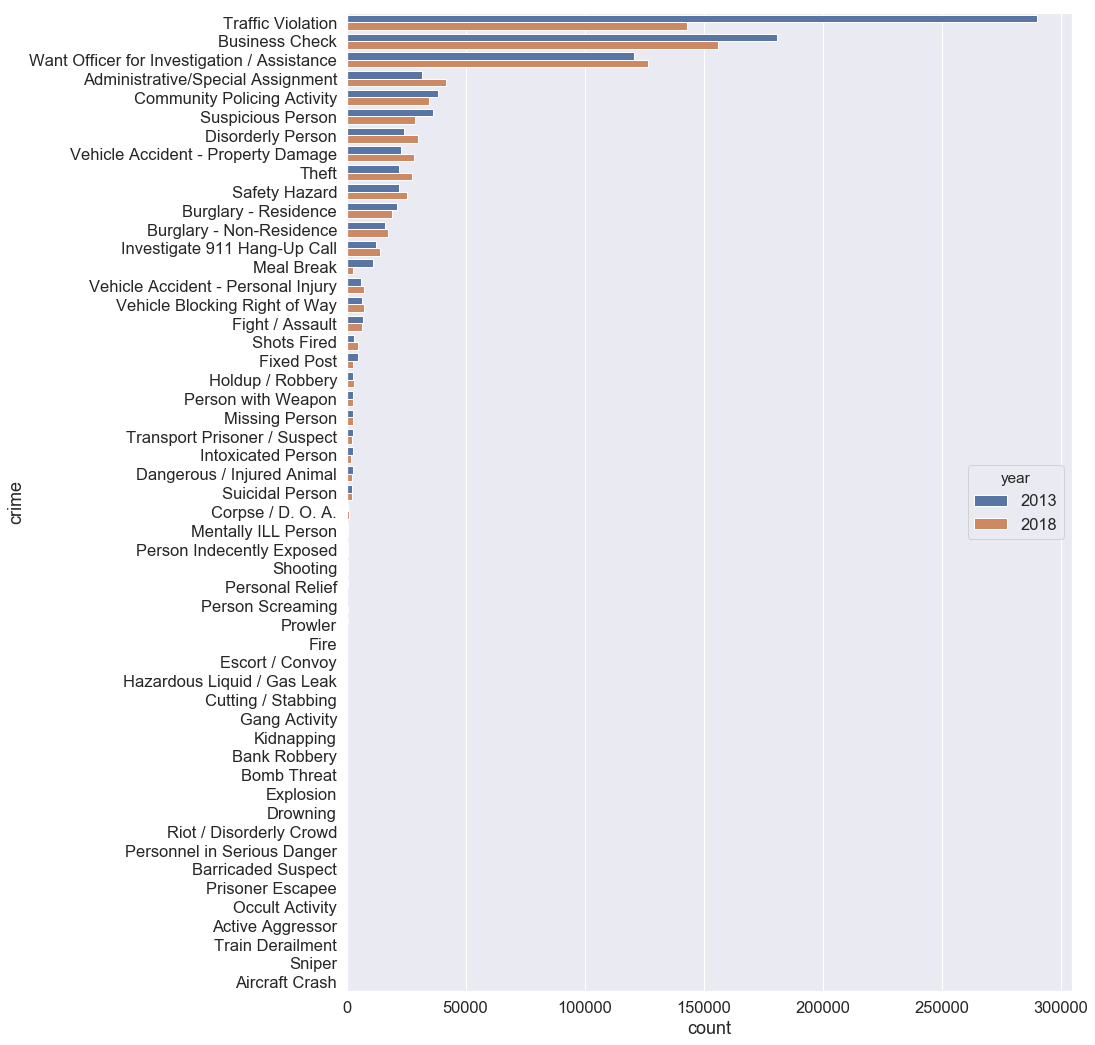

In [21]:
# Finding how many calls recieved for each tencode description on 2013
crime_2013 = police_2013['tencode_desc'].value_counts().index.tolist()
count_2013 = police_2013['tencode_desc'].value_counts().values.tolist()
crime_cnt_2013 = pd.DataFrame({ 'crime': crime_2013, 'count': count_2013})
crime_cnt_2013.sort_values('count', inplace = True)
crime_cnt_2013.reset_index(drop = True, inplace = True)

# Finding how many calls recieved for each tencode description on 2018
crime_2018 = police_2018['tencode_desc'].value_counts().index.tolist()
count_2018 = police_2018['tencode_desc'].value_counts().values.tolist()
crime_cnt_2018 = pd.DataFrame({ 'crime': crime_2018, 'count': count_2018})
crime_cnt_2018.sort_values('count', inplace = True)
crime_cnt_2018.reset_index(drop = True, inplace = True)

# Adding a year info to each subset
crime_cnt_2013['year'] = 2013
crime_cnt_2018['year'] = 2018

# Creating crime df by concatanating these two subset
crime_counts = pd.concat([crime_cnt_2013[:], crime_cnt_2018[:]])
crime_counts.sort_values('count', ascending=False, inplace = True)
crime_counts.reset_index(drop = True, inplace = True)

# Plotting a horizontal bar to compare 2013 and 2018 crime counts by type
plt.rcParams['figure.figsize'] = [13, 18]
sns.set(font_scale=1.5)
sns.barplot(orient='h', x='count', y='crime', hue='year', data=crime_counts)

## Looking if there is an accumulation for specific crime types on a unit

### 2013

In [23]:
# Finding the proportion of each unit on each crime type 
police_2013_crimes_unit = police_2013.groupby(['tencode_desc', 'unit']).count()['id'].to_frame()
dict_police_2013_crimes_counts = police_2013.groupby('tencode_desc').count()['id'].to_dict()
police_2013_crimes_unit.reset_index(inplace=True)
police_2013_crimes_unit['total_counts'] = police_2013_crimes_unit['tencode_desc'].map(dict_police_2013_crimes_counts)
police_2013_crimes_unit.rename(columns={'id':'unit_counts'}, inplace = True)
police_2013_crimes_unit['unit_percentage'] = 100*police_2013_crimes_unit['unit_counts']/police_2013_crimes_unit['total_counts']

# Creating a new dataframe by selecting minimum percentage on a crime type and minimum, maximum crime count
min_percentage = 2
min_count = 2
max_count = 3000
police_2013_crimes_high_perc_unit = police_2013_crimes_unit[((police_2013_crimes_unit['unit_percentage']>=min_percentage) &
                                                             (police_2013_crimes_unit['unit_counts']>=min_count) &
                                                           (police_2013_crimes_unit['unit_counts']<=max_count))]

# Adding location information of units
accumulated_unit_2013 = pd.merge(police_2013_crimes_high_perc_unit, unit_mean_loc_nash_police_2013, on='unit')
accumulated_unit_2013.sort_values(by='unit_percentage', ascending=False, inplace=True)

# Creating a bubble map to show units with high proportion of a specific crime type
accumulated_unit_map_2013 = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
accumulated_unit_map_2013.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

# Creating colors for each crime types
tencodes_2013 = police_2013_crimes_high_perc_unit.tencode_desc.value_counts().keys().tolist()
#cm.linear. Paired_12, Set1_08, Set1_07, Set3_12, Set1_09, Dark2_06, Set1_04, Set2_08, Set1_06, Dark2_07, Dark2_08
import branca.colormap as cm
colormap = cm.linear.Dark2_08
colors_2013 = []
for j in range(0, len(tencodes_2013)):
    colors_2013.append(str(colormap(j/len(tencodes_2013))))
tencode_colors_2013= dict(zip(tencodes_2013, colors_2013))

for i in range(0,int(len(accumulated_unit_2013))):
    folium.Circle(
        location=[float(accumulated_unit_2013.iloc[i]['lat']), float(accumulated_unit_2013.iloc[i]['lng'])],
        popup=accumulated_unit_2013.iloc[i]['tencode_desc']+'\n count:'+str(accumulated_unit_2013.iloc[i]['unit_counts'])+
        '\n percentage:' +str(int(accumulated_unit_2013.iloc[i]['unit_percentage'])),
        radius=int((accumulated_unit_2013.iloc[i]['unit_percentage'])*50),
        color=tencode_colors_2013.get(accumulated_unit_2013.iloc[i]['tencode_desc']),
        fill=True,
        fill_color=tencode_colors_2013.get(accumulated_unit_2013.iloc[i]['tencode_desc'])
   ).add_to(accumulated_unit_map_2013)

accumulated_unit_map_2013

In [24]:
accumulated_unit_2013.head()

tencode_desc  unit  unit_counts  total_counts  \
90  Personnel in Serious Danger  721B            2            14   
84              Personal Relief  415A           58           475   
66                   Fixed Post  5194          478          4603   
78      Riot / Disorderly Crowd  213B            2            22   
97      Riot / Disorderly Crowd   405            2            22   

    unit_percentage        lat        lng  
90        14.285714  36.253132 -86.753642  
84        12.210526  36.169375 -86.784640  
66        10.384532  36.157550 -86.706455  
78         9.090909  36.181457 -86.749815  
97         9.090909  36.163946 -86.779118

### 2018

In [25]:
# Finding the proportion of each unit on each specific crime type 
police_2018_crimes_unit = police_2018.groupby(['tencode_desc', 'unit']).count()['id'].to_frame()
dict_police_2018_crimes_counts = police_2018.groupby('tencode_desc').count()['id'].to_dict()
police_2018_crimes_unit.reset_index(inplace=True)
police_2018_crimes_unit['total_counts'] = police_2018_crimes_unit['tencode_desc'].map(dict_police_2018_crimes_counts)
police_2018_crimes_unit.rename(columns={'id':'unit_counts'}, inplace = True)
police_2018_crimes_unit['unit_percentage'] = 100*police_2018_crimes_unit['unit_counts']/police_2018_crimes_unit['total_counts']

# Creating a new dataframe by selecting minimum percentage on a crime type and minimum, maximum crime count
min_percentage = 2
min_count = 2
max_count = 3000
police_2018_crimes_high_perc_unit = police_2018_crimes_unit[((police_2018_crimes_unit['unit_percentage']>=min_percentage) &
                                                             (police_2018_crimes_unit['unit_counts']>=min_count) &
                                                           (police_2018_crimes_unit['unit_counts']<=max_count))]

# Adding location information of units
accumulated_unit_2018 = pd.merge(police_2018_crimes_high_perc_unit, unit_mean_loc_nash_police_2018, on='unit')
accumulated_unit_2018.sort_values(by='unit_percentage', ascending=False, inplace=True)

# Creating a bubble map to show units with high proportion of a specific crime type
accumulated_unit_map_2018 = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
accumulated_unit_map_2018.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

# Creating colors for each crime types
tencodes_2018 = police_2018_crimes_high_perc_unit.tencode_desc.value_counts().keys().tolist()

import branca.colormap as cm
colormap = cm.linear.Dark2_08
colors_2018 = []
for j in range(0, len(tencodes_2018)):
    colors_2018.append(str(colormap(j/len(tencodes_2018))))
tencode_colors_2018= dict(zip(tencodes_2018, colors_2018))

for i in range(0,int(len(accumulated_unit_2018))):
    folium.Circle(
        location=[float(accumulated_unit_2018.iloc[i]['lat']), float(accumulated_unit_2018.iloc[i]['lng'])],
        popup=accumulated_unit_2018.iloc[i]['tencode_desc']+'\n count:'+str(accumulated_unit_2018.iloc[i]['unit_counts'])+
        '\n percentage:' +str(int(accumulated_unit_2018.iloc[i]['unit_percentage'])),
        radius=int((accumulated_unit_2018.iloc[i]['unit_percentage'])*50),
        color=tencode_colors_2018.get(accumulated_unit_2018.iloc[i]['tencode_desc']),
        fill=True,
        fill_color=tencode_colors_2018.get(accumulated_unit_2018.iloc[i]['tencode_desc'])
   ).add_to(accumulated_unit_map_2018)

accumulated_unit_map_2018

In [26]:
accumulated_unit_2018.head()

tencode_desc  unit  unit_counts  total_counts  \
32              Escort / Convoy  2925          309           346   
22              Personal Relief  521A           35           237   
78  Personnel in Serious Danger  423A            2            20   
71              Personal Relief  522A           18           237   
16                 Bank Robbery  821A            7            94   

    unit_percentage        lat        lng  
32        89.306358  36.138735 -86.801408  
22        14.767932  36.188788 -86.634115  
78        10.000000  36.157323 -86.775772  
71         7.594937  36.189037 -86.633819  
16         7.446809  36.127336 -86.776203

### Looking and Comparing for specific crime types

C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\envs\NSS_jumpstart\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


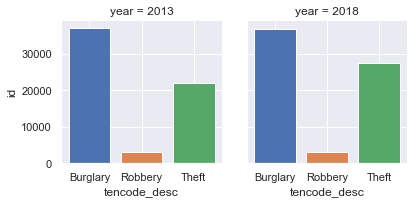

In [27]:
# Creating subset for specific tencode description
sub_police_2013 = police_2013[police_2013['tencode_desc'].isin(
        ['Holdup / Robbery', 'Bank Robbery', 'Burglary - Residence', 
         'Burglary - Non-Residence', 'Theft'])]

# Creating subset for specific tencode description
sub_police_2018 = police_2018[police_2018['tencode_desc'].isin(
        ['Holdup / Robbery', 'Bank Robbery', 'Burglary - Residence', 
         'Burglary - Non-Residence', 'Theft'])]

# Adding a year info to each subset
sub_police_2013['year'] = 2013
sub_police_2018['year'] = 2018

# Creating crime df by concatanating these two subset
crimes = pd.concat([sub_police_2013, sub_police_2018])

# Changing tencode descriptions (gathering robbery / burglary)
old_tencode_desc = crimes['tencode_desc'].value_counts().keys().tolist()
new_tencode_desc = ['Theft', 'Burglary', 'Burglary', 'Robbery', 'Robbery']
changing_desc = dict( zip( old_tencode_desc, new_tencode_desc))
crimes['tencode_desc'] = crimes['tencode_desc'].map(changing_desc)

# Creating another df aggregated with year,crime category, and 
# count of calls for the year and category
aggregated = crimes.groupby(['year', 'tencode_desc']).count()

# Reset index to be able to choose data according to year and id values
rst_aggregated = aggregated.reset_index()

# Plotting these specific crime counts for 2013 and 2018
sns.set(font_scale=1)
sns.FacetGrid(rst_aggregated, col = 'year', hue = 'tencode_desc').map(plt.bar, 'tencode_desc', 'id')

# Plotting gone robberies

In [28]:
# Looking for the robberies which is gone on arrival
gone_crimes = crimes[crimes.disposition_desc.str.contains('GONE ON ARRIVAL', na = False)]
gone_crimes = gone_crimes[gone_crimes.tencode_desc.str.contains('Robbery', na = False)]
gone_crimes.dropna(subset=['lat', 'lng'], inplace = True)

# Show Gone on arrival robberies on a map with markers
from folium.plugins import MarkerCluster

m = folium.Map(location=[36.1612, -86.7775])
sig = 0.2
m.fit_bounds([[36.1612+sig, -86.7775+sig], [36.1612-sig, -86.7775-sig]])

nash_map = folium.plugins.MarkerCluster().add_to(m)

for i in range(0,len(gone_crimes)):
    folium.Marker(
        location=[gone_crimes.iloc[i]['lat'], gone_crimes.iloc[i]['lng']],
        ).add_to(nash_map)

m